### Comparing the Color of Lenses

Jenny Kim, Phil Marshall

The OM10 mock lensed quasar catalog `qso_mock.fits` contains estimates of the lens galaxy $i$-band magnitudes, based on a simple Faber-Jackson scaling implemented by Phil Marshall. With the `lenspop` library we can compute synthetic magnitudes in any filter. In this notebook, we will look at the differences in the distributions of the 1) redshift, 2) $i$-band magnitude, 3) $G-R$ magnitude, 4) $R-I$ magnitude, and 5) $I-Z$ magnitude between the known SDSS values and the colored magnitudes for each lens by drawing a cornerplot.

### Requirements

`om10`, `qso_mock.fits`, and `om10`'s dependencies:

In [1]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
from __future__ import division
import os, numpy as np
import corner
import om10
from om10 import plotting
from astropy.table import Table
import matplotlib
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

First, let's read the catalog and select 200 lenses whose magnitudes are smaller than 23.6. Then, let's paint the lenses.

In [3]:
%%capture
db = om10.DB(catalog='/Users/Jenny/Desktop/om10fork/om10/data/qso_mock.fits')
db.select_random(Nlens=200,maglim=23.6)
db.paint(synthetic=True, target='lens')

Draw the cornerplot with the arguments in axis_labels and save it first so that we could overlap it with the second cornerplot. Two cornerplot seems too many, but corner.corner automatically displays the cornerplot in jupyter. However, using %%capture suppresses the output.

In [4]:
#om10 uses usetex=True, which sometimes generates error when using matplotlib. To be safe, let's disable usetex.
matplotlib.rc('text', usetex=False)
# Columns : ra  dec  z  mag_u  mag_g  mag_r  mag_i  mag_z
table = np.loadtxt('../data/SDSS_LRGs.txt')
# eliminate outliers using original data
table = table[np.logical_and(table[:,6]<20, table[:,2]<3, 14<table[:,6])]
z = table[:,2]
i = table[:,6]
gr = table[:,4]-table[:,5]
ri = table[:,5]-table[:,6]
iz = table[:,6]-table[:,7]

Then, we need to weight the mocked lenses with respect to the parent population. The parent population would be gaussian distributed, and the mean would be given by $np.mean(z)$ and the standard deviation would be given by $np.std(z)$.

The weight could be calculated by using this formula:

$$\frac { P(redshift) }{ Q(redshift) } $$

where P(redshift) is a y-value of redshift in the parent normal distribution and Q(redshift) is a y-value of redshift in the mock, colored lenses. `gaussian_reweight` method in OM10 does the calculation.

In [5]:
%%capture
db.gaussian_reweight(np.mean(z), np.std(z))
fig = om10.plot_sample(db.sample, color='blue', weight=True, parameters=('MAGI','ZLENS', 'GR', 'RI', 'IZ'))

Then, we will overlap the synthetically colored samples with the original data. Ideally, the distributions of the data should look similar, and the blue contours and the red contours should have significant overlap. While plotting the data onto the cornerplot, we should eliminate the outliers.

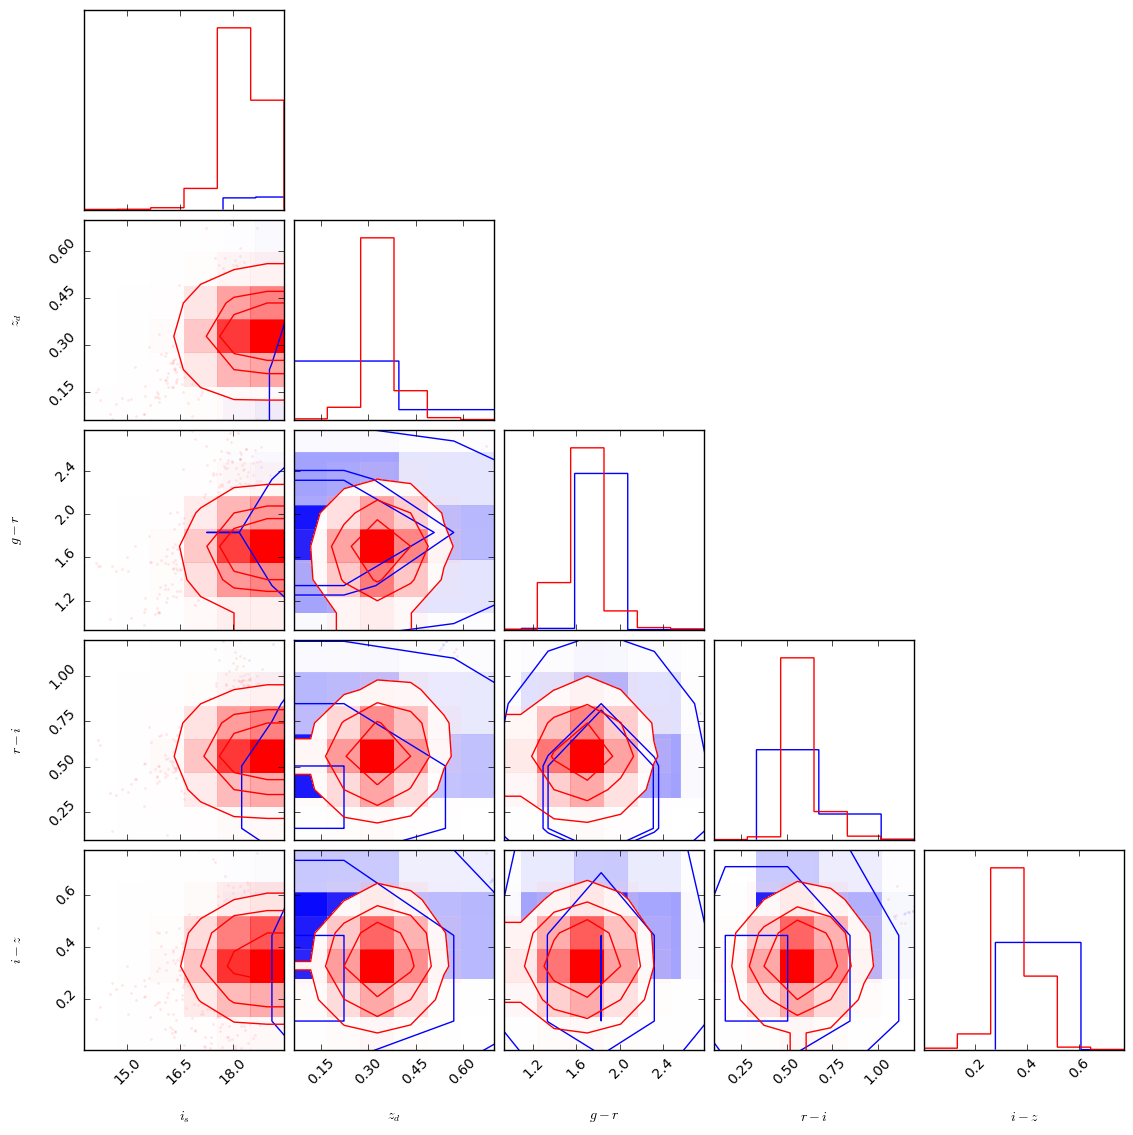

In [6]:
# eliminate outliers after the operation
z = z[(0<table[:,6]-table[:,7]) & (table[:,4]-table[:,5]<2.8)]
i = i[(0<table[:,6]-table[:,7]) & (table[:,4]-table[:,5]<2.8)]
gr = gr[(0<table[:,6]-table[:,7]) & (table[:,4]-table[:,5]<2.8)]
ri = ri[(0<table[:,6]-table[:,7]) & (table[:,4]-table[:,5]<2.8)]
iz = iz[(0<table[:,6]-table[:,7]) & (table[:,4]-table[:,5]<2.8)]

data = Table({'MAGI': i, 'ZLENS': z, 'GR': gr, 'RI': ri, 'IZ': iz}, names=['MAGI', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('MAGI','ZLENS', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.0, fig=fig, hist_kwargs=dict(normed=True))

### Discussion

Red(the real data) and the blue(synthetically colored data) contours look really similar to each other. Because of the very first histogram, we suspected that there would be a lot more data beyond $~19$ magnitude, but the maximum magnitude in $i$ array was 19.45698.